# AMLB shorter runs visualizations
This notebook contains code to generate critical difference diagrams.

In [15]:
import itertools
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import Orange

from visualization_early import FRAMEWORK_TO_COLOR
from data_processing import get_print_friendly_name, impute_missing_results, calculate_ranks, is_old

In [2]:
PROJECT_ROOT = Path(".").absolute().parent
DATA_DIRECTORY = PROJECT_ROOT / "data"
FIGURE_DIRECTORY = PROJECT_ROOT / "figures" / "CD"
FIGURE_DIRECTORY.mkdir(parents=True, exist_ok=True)
FIGURE_DIRECTORY_BY_TIME = PROJECT_ROOT / "figures" / "CD_by_time"
FIGURE_DIRECTORY_BY_TIME.mkdir(parents=True, exist_ok=True)

In [3]:
results = pd.read_csv(DATA_DIRECTORY / "amlb_all.csv", dtype={"info": str})
results = results[~results["framework"].isin(["autosklearn2"])]
results["framework"] = results["framework"].apply(get_print_friendly_name)

In [4]:
results.framework.unique()

array(['AutoGluon(HQIL)_10min', 'AutoGluon(HQIL)_30min',
       'AutoGluon(HQIL)_5min', 'AutoGluon(HQIL)_60min',
       'AutoGluon(HQ)_10min', 'AutoGluon(HQ)_30min', 'AutoGluon(HQ)_5min',
       'AutoGluon(HQ)_60min', 'AutoGluon(B)_10min', 'AutoGluon(B)_30min',
       'AutoGluon(B)_5min', 'AutoGluon(B)_60min', 'FEDOT_10min',
       'FEDOT_30min', 'FEDOT_5min', 'FEDOT_60min', 'GAMA(B)_10min',
       'GAMA(B)_30min', 'GAMA(B)_5min', 'GAMA(B)_60min',
       'H2OAutoML_10min', 'H2OAutoML_30min', 'H2OAutoML_5min',
       'H2OAutoML_60min', 'NaiveAutoML_10min', 'NaiveAutoML_30min',
       'NaiveAutoML_5min', 'NaiveAutoML_60min', 'RF_60min', 'TPOT_10min',
       'TPOT_30min', 'TPOT_5min', 'TPOT_60min', 'TRF_60min',
       'autosklearn2_10min', 'autosklearn2_30min', 'autosklearn2_5min',
       'autosklearn2_60min', 'autosklearn_10min', 'autosklearn_30min',
       'autosklearn_5min', 'autosklearn_60min', 'CP_60min', 'flaml_10min',
       'flaml_30min', 'flaml_5min', 'flaml_60min', 'lightautoml_

In [5]:
from IPython.display import display

with pd.option_context("display.max_rows", None):
    display(results.groupby(by=["constraint", "framework"]).size())

constraint              framework            
Mixed Time Constraints  AutoGluon(B)_10min       1040
                        AutoGluon(B)_30min       1040
                        AutoGluon(B)_5min        1040
                        AutoGluon(B)_60min       1040
                        AutoGluon(HQ)_10min      1040
                        AutoGluon(HQ)_30min      1040
                        AutoGluon(HQ)_5min       1040
                        AutoGluon(HQ)_60min      1040
                        AutoGluon(HQIL)_10min    1040
                        AutoGluon(HQIL)_30min    1040
                        AutoGluon(HQIL)_5min     1040
                        AutoGluon(HQIL)_60min    1040
                        CP_60min                 1040
                        FEDOT_10min              1040
                        FEDOT_30min              1040
                        FEDOT_5min               1040
                        FEDOT_60min              1040
                        GAMA(B)_10mi

### Errors plot

C:\Users\20210595\AppData\Local\Temp\ipykernel_37968\298193012.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_results['framework'] = time_filtered_results['framework'].str.replace(f"_{time}", '')


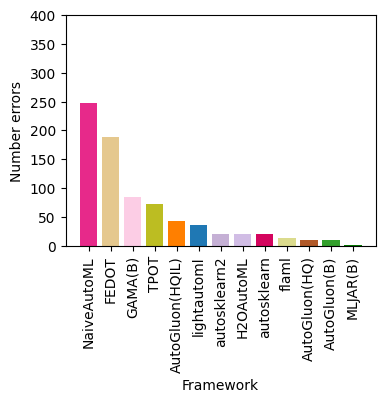

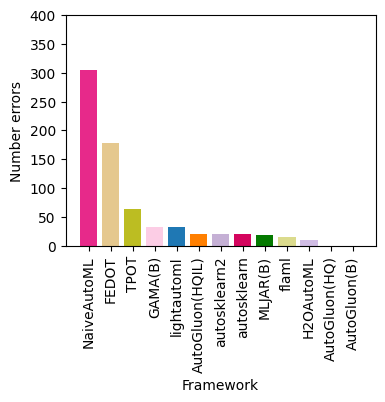

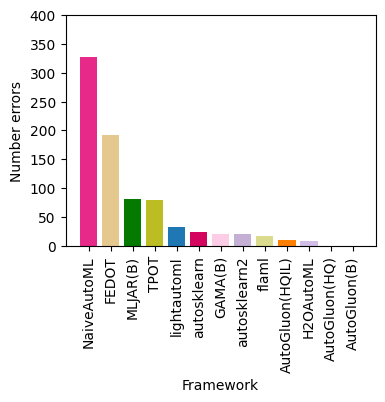

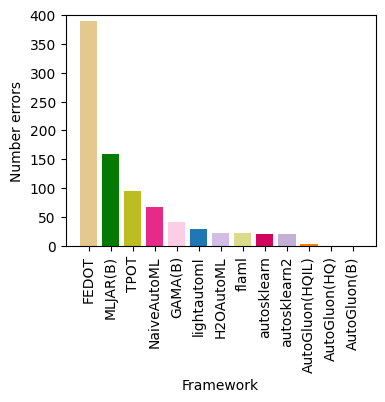

In [6]:
import pandas as pd
import os
import matplotlib.pyplot as plt

exclude_frameworks = ['CP', 'RF', 'TRF']
time_strings = ['5min', '10min', '30min', '60min']

# Filter DataFrame for rows where 'framework' contains any of the time strings
filtered_results = results[results['framework'].str.contains('|'.join(time_strings))]

# Dictionary to store NaN counts per framework per time string
nan_counts = {time: {} for time in time_strings}

# Iterate over each time string
for time in time_strings:
    
    # Filter DataFrame for the current time string
    time_filtered_results = filtered_results[filtered_results['framework'].str.contains(time)]

    # Remove the time string from the 'framework' column
    time_filtered_results['framework'] = time_filtered_results['framework'].str.replace(f"_{time}", '')
    
        
    # Exclude specific frameworks
    time_filtered_results = time_filtered_results[~time_filtered_results['framework'].str.contains('|'.join(exclude_frameworks))]
    
    # Iterate over each unique framework
    for framework in time_filtered_results['framework'].unique():
        # Count the number of NaN values in the 'result' column for the current framework
        nan_count = time_filtered_results[time_filtered_results['framework'] == framework]['result'].isna().sum()
        nan_counts[time][framework] = nan_count

# Plot bar plots for each time string
for time, counts in nan_counts.items():
    # Sort the counts dictionary by values in descending order
    sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
    
    plt.figure(figsize=(4, 3))
    bars = plt.bar(sorted_counts.keys(), sorted_counts.values(), color=[FRAMEWORK_TO_COLOR.get(framework, 'gray') for framework in sorted_counts.keys()])
    plt.xlabel('Framework')
    plt.ylabel('Number errors')
    # plt.title(f'Number of errors per framework for {time}')
    plt.xticks(rotation=90)
    plt.ylim(0, 400)

    # Save the figure
    filename = f"{time}_errors_per_framework.png"
    filepath = os.path.join(FIGURE_DIRECTORY, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    
    plt.show()

# CD Plots

In [7]:
# Define a function to replace the prefix
def replace_prefix(framework, prefix):
    if framework.startswith(prefix):
        return framework[len(prefix):]
    return framework

In [8]:
def plot_cd(results, filename=None):
    ranks = calculate_ranks(results)
    n_tasks = results["task"].nunique()
    critical_difference = Orange.evaluation.compute_CD(ranks.values(), n_tasks)
    Orange.evaluation.graph_ranks(
        ranks.values(),
        list(ranks),
        cd=critical_difference,
        width=6,
        textspace=1.5,
        filename=filename,
        bbox_inches='tight'
    )
    plt.title(filename.name)
    return ranks

In [9]:
strings_in_framewokrs = ['AutoGluon(B)', 'AutoGluon(HQ)', 'AutoGluon(HQIL)', 'flaml', 'TPOT', 'lightautoml',
       'MLJAR(B)', 'GAMA(B)', 'H2OAutoML', 'NaiveAutoML', 'FEDOT', 'autosklearn'] 

In [10]:
name_mapping = {
    'constantpredictor_60min': 'CP_60min',
    'RandomForest_60min': 'RF_60min',
    'TunedRandomForest_60min': 'TRF_60min'
}

This is the frameworks AutoGluon(B)


C:\Users\20210595\AppData\Local\Temp\ipykernel_37968\4108255294.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))


generating cd-general-AutoGluon(B).png
This is the frameworks AutoGluon(HQ)
generating cd-general-AutoGluon(HQ).png
This is the frameworks AutoGluon(HQIL)
generating cd-general-AutoGluon(HQIL).png
This is the frameworks flaml
generating cd-general-flaml.png
This is the frameworks TPOT
generating cd-general-TPOT.png
This is the frameworks lightautoml
generating cd-general-lightautoml.png
This is the frameworks MLJAR(B)
generating cd-general-MLJAR(B).png
This is the frameworks GAMA(B)
generating cd-general-GAMA(B).png
This is the frameworks H2OAutoML
generating cd-general-H2OAutoML.png
This is the frameworks NaiveAutoML
generating cd-general-NaiveAutoML.png
This is the frameworks FEDOT
generating cd-general-FEDOT.png
This is the frameworks autosklearn
generating cd-general-autosklearn.png


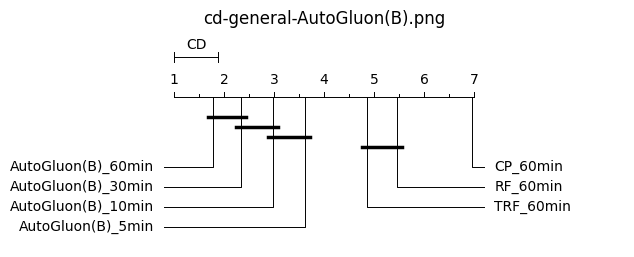

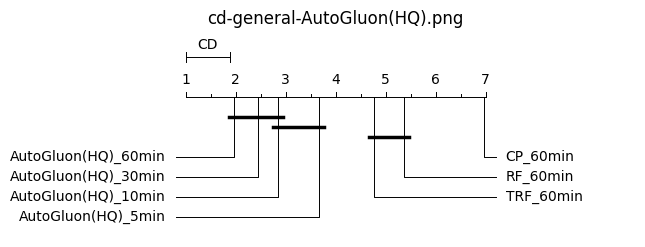

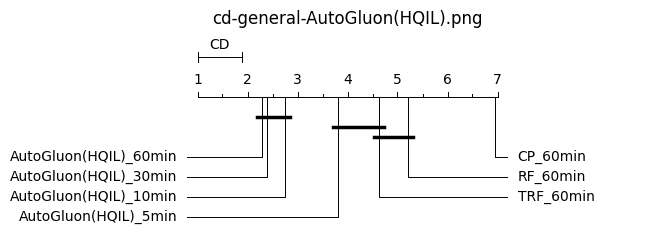

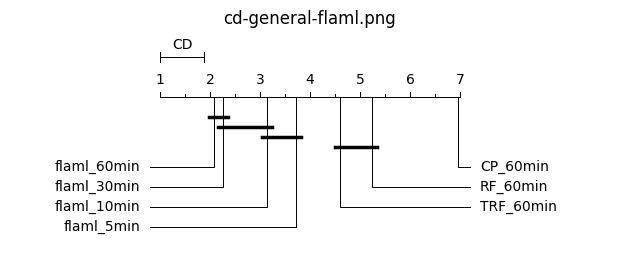

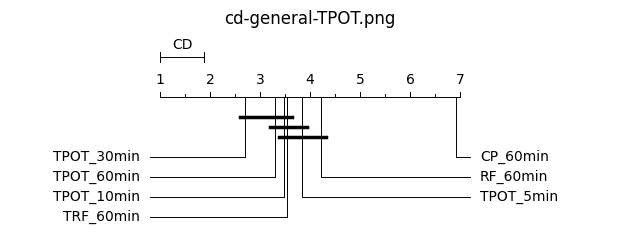

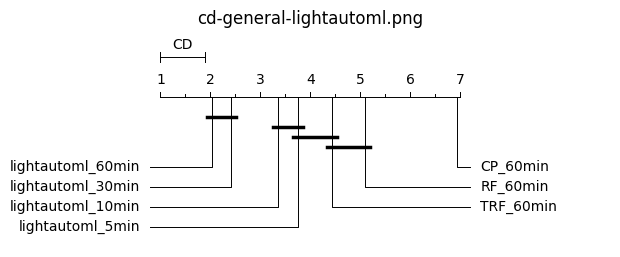

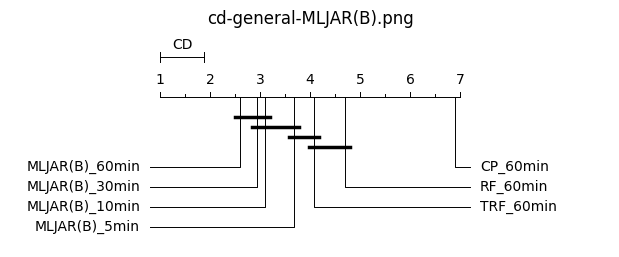

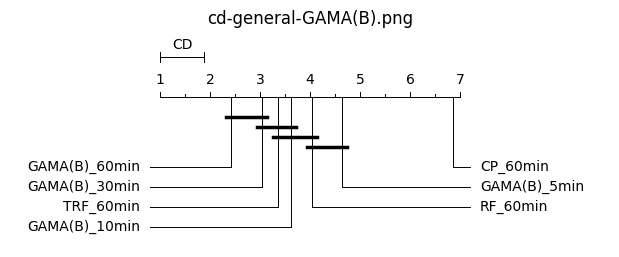

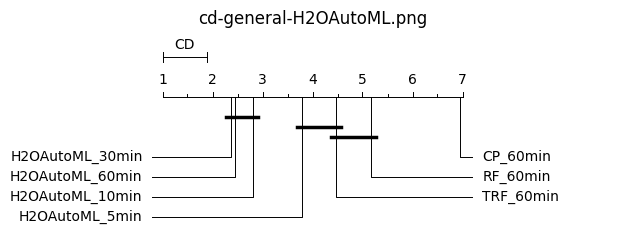

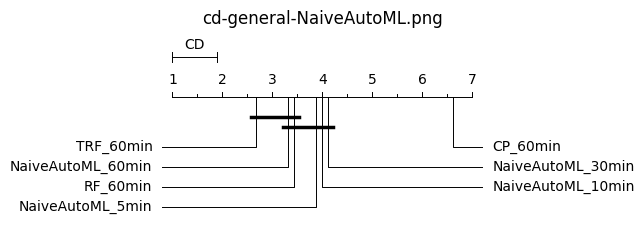

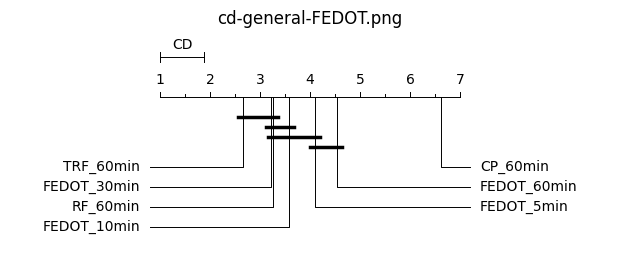

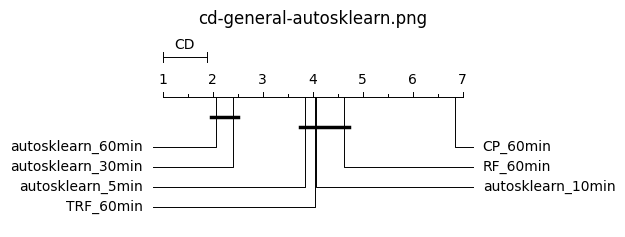

In [11]:
for name_fr in strings_in_framewokrs:
    print("This is the frameworks", name_fr)
    this_framework = results[results['framework'].isin([f'{name_fr}_5min', f'{name_fr}_10min', f'{name_fr}_30min', f'{name_fr}_60min', 'RF_60min', 'TRF_60min', 'CP_60min'])]
    this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))
    data = this_framework
    data = impute_missing_results(data, with_results_from="CP_60min")
    filename = f"cd-general-{name_fr}.png"
    print("generating", filename)
    plot_cd(data, filename=FIGURE_DIRECTORY / filename)

### All frameworks by time

In [12]:
strings_by_time = ['_5min', '_10min', '_30min', '_60min']
extra_frameworks = ['RF_60min', 'TRF_60min', 'CP_60min']

This is the time constraint _5min


C:\Users\20210595\AppData\Local\Temp\ipykernel_37968\2531160696.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_dataframe['framework'] = this_dataframe['framework'].apply(lambda x: name_mapping.get(x, x))


generating cd-general_5min.png
This is the time constraint _10min
generating cd-general_10min.png
This is the time constraint _30min
generating cd-general_30min.png
This is the time constraint _60min
generating cd-general_60min.png


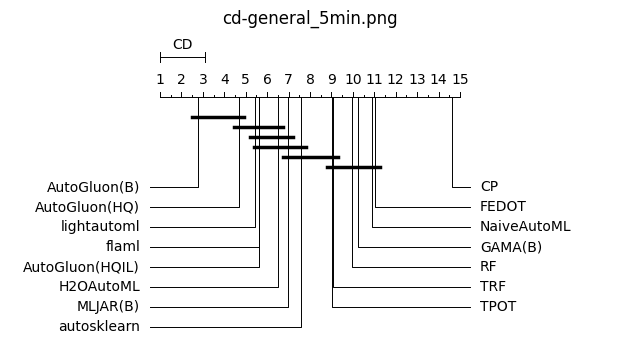

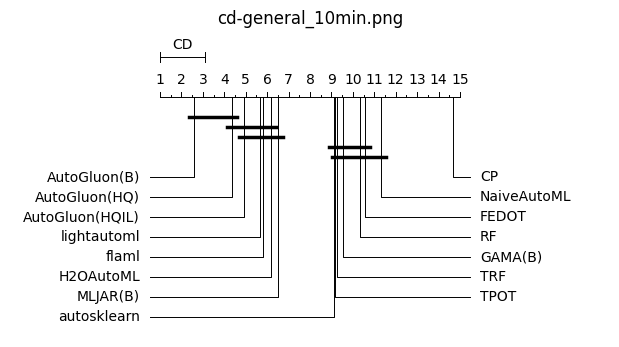

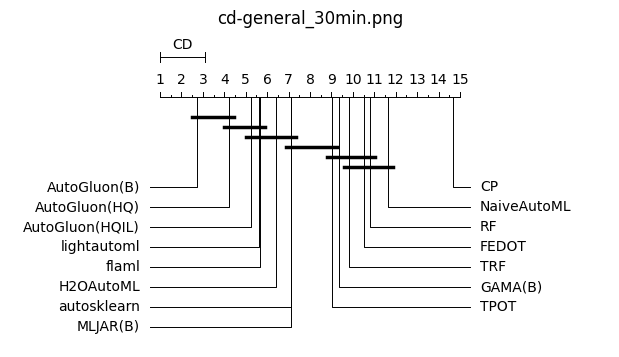

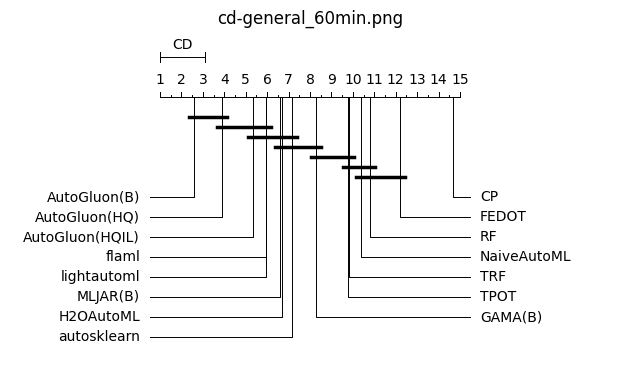

In [13]:
correlation_dictionary = dict()
for name_time in strings_by_time:
    print("This is the time constraint", name_time)
    this_dataframe = results[results['framework'].str.contains(name_time) | results['framework'].isin(extra_frameworks)]
    this_dataframe['framework'] = this_dataframe['framework'].apply(lambda x: name_mapping.get(x, x))
    this_dataframe = this_dataframe[~this_dataframe['framework'].str.contains('autosklearn2')]
    data = this_dataframe
    data = impute_missing_results(data, with_results_from="CP_60min")
    data['framework'] = data['framework'].apply(lambda x: x.replace(name_time, ''))
    data['framework'] = data['framework'].apply(lambda x: x.replace("_60min", ''))
    filename = f"cd-general{name_time}.png"
    print("generating", filename)
    correlation_dictionary[name_time.replace("_", "")] = plot_cd(data, filename=FIGURE_DIRECTORY_BY_TIME / filename)

### Correlation matrix

In [14]:
# Create a DataFrame
df_corr = pd.DataFrame(correlation_dictionary)

# Optionally, transpose the DataFrame if you want the times as columns
correlation_table = df_corr.corr()

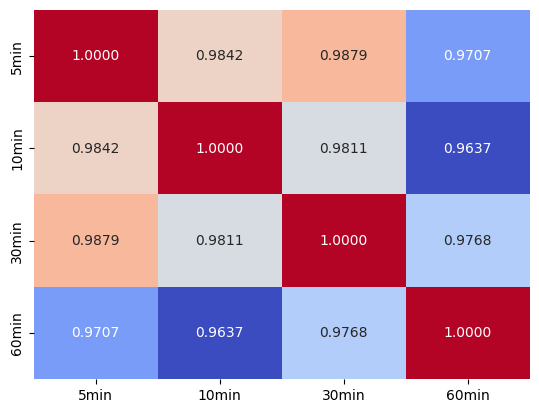

In [16]:
fig, ax = plt.subplots()
sns.heatmap(correlation_table, annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels())
plt.savefig(FIGURE_DIRECTORY_BY_TIME/"correlation.png", bbox_inches='tight', dpi=300)

### AutoGluon evaluation (extra plot for fun)

In [17]:
list_to_use = list(results.framework.unique())
filtered_list = [item for item in list_to_use if 'AutoGluon(B)' in item or '60min' in item]
filtered_list = [item for item in filtered_list if 'AutoGluon(HQIL)' not in item and 'AutoGluon(HQ)' not in item]
this_dataframe = results[results['framework'].isin(filtered_list)]

C:\Users\20210595\AppData\Local\Temp\ipykernel_37968\3242941875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_dataframe['framework'] = this_dataframe['framework'].apply(lambda x: name_mapping.get(x, x))


generating cd-general_test.png


{'AutoGluon(B)_10min': 4.663461538461538,
 'AutoGluon(B)_30min': 3.7596153846153846,
 'AutoGluon(B)_5min': 5.798076923076923,
 'AutoGluon(B)_60min': 2.8846153846153846,
 'CP_60min': 15.6875,
 'FEDOT_60min': 13.182692307692308,
 'GAMA(B)_60min': 9.201923076923077,
 'H2OAutoML_60min': 7.4423076923076925,
 'MLJAR(B)_60min': 7.4375,
 'NaiveAutoML_60min': 11.427884615384615,
 'RF_60min': 11.711538461538462,
 'TPOT_60min': 10.6875,
 'TRF_60min': 10.692307692307692,
 'autosklearn_60min': 8.004807692307692,
 'flaml_60min': 6.644230769230769,
 'lightautoml_60min': 6.774038461538462}

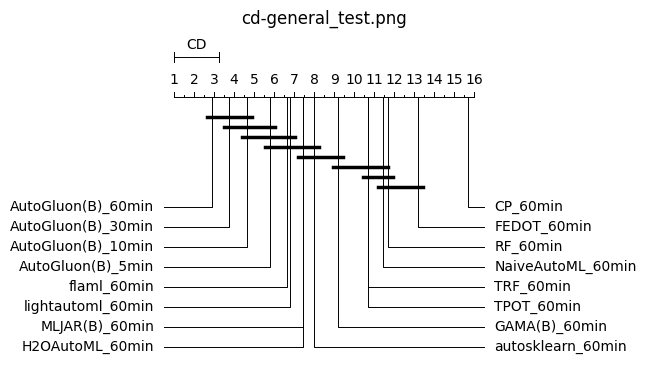

In [18]:
this_dataframe['framework'] = this_dataframe['framework'].apply(lambda x: name_mapping.get(x, x))
this_dataframe = this_dataframe[~this_dataframe['framework'].str.contains('autosklearn2')]
data = this_dataframe
data = impute_missing_results(data, with_results_from="CP_60min")

filename = "cd-general_test.png"
print("generating", filename)
plot_cd(data, filename=FIGURE_DIRECTORY_BY_TIME / filename)